In [1]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()


In [2]:

!pip install -U "transformers>=4.43" "accelerate>=0.33" "peft>=0.12.0" bitsandbytes datasets evaluate scikit-learn sentence-transformers tqdm matplotlib numpy


# Initial Configuration

In [3]:

import os, json, math, time, random, gc
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import torch

from datasets import load_dataset, DatasetDict
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, f1_score
)

from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig, TrainingArguments, Trainer, set_seed
)

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import matplotlib.pyplot as plt

# --- project config ---
CONFIG = {
    # models
    #"PROMPT_MODEL": "meta-llama/Meta-Llama-3.1-8B-Instruct",
    
    "PROMPT_MODEL": "meta-llama/Meta-Llama-3.1-8B",


    "LORA_BASE_MODEL": "meta-llama/Meta-Llama-3.1-8B",

    # data (pubmed_qa pqa_labeled)
    "DATASET_NAME": "pubmed_qa",
    "DATASET_CONFIG": "pqa_labeled",

    # training switch
    #"USE_QLORA": True,                # True: train,eval LoRA; False: prompt-only baselines
    "USE_QLORA": False,

    
    # qlora hyperparams
    "QLORA_RANKS": [16],
    "LORA_ALPHA": 32,
    "LORA_DROPOUT": 0.1,
    "TARGET_MODULES": ["q_proj","k_proj","v_proj","o_proj","up_proj","down_proj","gate_proj"],

    # optimization
    "EPOCHS": 5,
    "LR": 3e-5,#3e-5
    "WARMUP_RATIO": 0.1,
    "PER_DEVICE_TRAIN_BS": 1,
    "PER_DEVICE_EVAL_BS": 1,
    "GRAD_ACCUM_STEPS": 16,

    # sequence lengths
    "MAX_INPUT_TOKENS": 750,#750
    "MAX_NEW_TOKENS": 4,              # classification over {yes,no,maybe}

    # prompt strategies (used only when USE_QLORA=False)
    "PROMPT_STYLES": ["zero", "domain", "cot"],

    # system / logging
    "BF16": True,
    "REPORT_TO": "none",
    "WORK_DIR": "./runs_pubmedqa",
    "SEED": 42,

    # trial caps (None means full split)
    "TRIAL_LIMIT_TRAIN": None,
    "TRIAL_LIMIT_TEST": None,


     # generation hyperparameters
    "GENERATION_TEMPERATURE": 0.3,   # lower for classification tasks
    "TOP_P": 0.9,                     # optional nucleus sampling
    "DO_SAMPLE": True,                 # must be True to use temperature
}

os.makedirs(CONFIG["WORK_DIR"], exist_ok=True)


HF_TOKEN = os.environ.get("HF_TOKEN", None)  

# --- reproducibility ---
set_seed(CONFIG["SEED"])
random.seed(CONFIG["SEED"])
np.random.seed(CONFIG["SEED"])
torch.manual_seed(CONFIG["SEED"])

# --- device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

# --- labels and parsing helpers ---
LABELS = ["yes", "no", "maybe"]
LABEL2ID = {l: i for i, l in enumerate(LABELS)}
ID2LABEL = {i: l for l, i in LABEL2ID.items()}

def parse_label(text: str) -> str:
    """extract one of {yes,no,maybe} from decoded generation text."""
    t = text.strip().lower()
    for lab in LABELS:
        if lab in t:
            return lab
    return "maybe"

# --- prompt builders ---
def build_prompt(question: str, context: str, style: str = "domain") -> str:
    """return a prompt string according to style."""
    if style == "zero":
        return (
            "You are a helpful assistant for biomedical QA.\n"
            f"Question: {question}\n"
            f"Context: {context}\n"
            "Answer exactly one word: yes, no, or maybe.\n"
            "Answer:"
        )
    if style == "cot":
        return (
            "You are a biomedical QA assistant. Think step by step.\n"
            f"Question: {question}\n"
            f"Context: {context}\n"
            "First reason step-by-step, then on a new line output: Final answer: yes or no or maybe.\n"
            "Reasoning:"
        )
    # default: domain
    return (
        "You are a biomedical QA assistant specialized in PubMed abstracts.\n"
        "Use the context to answer exactly one word among: yes, no, maybe.\n\n"
        f"Question: {question}\n"
        f"Context: {context}\n\n"
        "Answer:"
    )



def safe_float(x, default=0.0):
    try:
        xf = float(x)
        if math.isnan(xf) or math.isinf(xf):
            return default
        return xf
    except Exception:
        return default

def ensure_dir(p: str) -> str:
    os.makedirs(p, exist_ok=True)
    return p

print("CONFIG and utilities ready.")


/home/jovyan/Convential/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda
CONFIG and utilities ready.


# Load and normalize PubMedQA Dataset 

In [4]:
from datasets import load_dataset, DatasetDict


def normalize_label(lbl: str) -> str:
    lbl = (lbl or "").strip().lower()
    if lbl in {"yes", "y", "true"}:
        return "yes"
    if lbl in {"no", "n", "false"}:
        return "no"
    return "maybe"

def to_record(ex):
    q = (ex.get("question") or "").strip()

    # handle context as string or list
    cx = ex.get("context") or ex.get("abstract") or ""
    if isinstance(cx, list):
        cx = " ".join([str(x).strip() for x in cx])
    else:
        cx = str(cx).strip()

    y = normalize_label(ex.get("final_decision") or ex.get("label") or "")
    return {"question": q, "context": cx, "label": y}

# load raw dataset
ds_raw = load_dataset(CONFIG["DATASET_NAME"], CONFIG["DATASET_CONFIG"])

# ensure we have at least train / test
if "train" not in ds_raw:
    raise ValueError("This dataset must provide a 'train' split or be splittable.")

if "test" in ds_raw:
    ds_work = DatasetDict({k: ds_raw[k] for k in ds_raw.keys()})
elif "validation" in ds_raw:
    ds_work = DatasetDict(train=ds_raw["train"], test=ds_raw["validation"])
else:
    tmp = ds_raw["train"].train_test_split(test_size=0.15, seed=CONFIG["SEED"])
    ds_work = DatasetDict(train=tmp["train"], test=tmp["test"])

# normalize columns to a common schema
ds = DatasetDict({
    split: ds_work[split].map(to_record, remove_columns=ds_work[split].column_names)
    for split in ds_work.keys()
})

if CONFIG.get("TRIAL_LIMIT_TRAIN"):
    n = min(len(ds["train"]), int(CONFIG["TRIAL_LIMIT_TRAIN"]))
    ds["train"] = ds["train"].select(range(n))

if CONFIG.get("TRIAL_LIMIT_TEST"):
    n = min(len(ds["test"]), int(CONFIG["TRIAL_LIMIT_TEST"]))
    ds["test"] = ds["test"].select(range(n))

# constrain labels to {yes,no,maybe}
LABELS = ["yes", "no", "maybe"]
for split in list(ds.keys()):
    ds[split] = ds[split].filter(lambda ex: ex["label"] in LABELS)

# basic checks and summary
for split in ["train", "test"]:
    if split not in ds:
        raise ValueError(f"Required split '{split}' is missing after preparation.")

print("splits available:", list(ds.keys()))
print("train size:", len(ds["train"]))
print("test size:", len(ds["test"]))
if "validation" in ds:
    print("validation size:", len(ds["validation"]))


splits available: ['train', 'test']
train size: 850
test size: 150


#  Tokenizer setup 


In [5]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained(
    CONFIG["PROMPT_MODEL"],
    token=HF_TOKEN if HF_TOKEN else None
)


if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print("tokenizer loaded:", CONFIG["PROMPT_MODEL"])
print("pad_token:", tokenizer.pad_token, "id:", tokenizer.pad_token_id)


tokenizer loaded: meta-llama/Meta-Llama-3.1-8B
pad_token: <|end_of_text|> id: 128001


# Prompt builders for different methods 


In [7]:

def build_prompt(question: str, context: str, style: str = "domain") -> str:
    """
    Build a prompt for PubMedQA depending on the chosen style.
    style options: "zero", "domain", "cot"
    """
    if style == "zero":
        return (
            "You are a helpful biomedical QA assistant .\n"
            f"Question: {question}\n"
            f"Context: {context}\n"
            "Answer with exactly one word: yes, no, or maybe.\nAnswer:"
        )
    elif style == "cot":
        return (
            "You are a biomedical QA assistant. Think step by step.\n"
            f"Question: {question}\n"
            f"Context: {context}\n"
            "First reason step-by-step, then on a new line output: "
            "Final answer: yes or no or maybe.\nReasoning:"
        )
    else:  # domain-specific
        return (
            "You are a biomedical QA assistant specialized in PubMed abstracts.\n"
            "Use the context to answer exactly one word among: yes, no, maybe.\n\n"
            f"Question: {question}\n"
            f"Context: {context}\n\nAnswer:"
        )

print("prompt builder ready. available styles:", CONFIG["PROMPT_STYLES"])


prompt builder ready. available styles: ['zero', 'domain', 'cot']


#  Label scoring utilities 


In [8]:

import torch
import torch.nn.functional as F
from collections import OrderedDict

# fixed label set
LABELS = ["yes", "no", "maybe"]

# use a leading space for LLaMA tokenization
VERBALIZERS = OrderedDict({
    "yes":   " yes",
    "no":    " no",
    "maybe": " maybe",
})

def _first_real_device(model: torch.nn.Module) -> torch.device:
    for p in model.parameters():
        if getattr(p, "device", None) and p.device.type != "meta":
            return p.device
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _label_id_seqs(tokenizer) -> dict[str, torch.Tensor]:
    seqs = {}
    for lab, text in VERBALIZERS.items():
        ids = tokenizer.encode(text, add_special_tokens=False)
        if not ids:
            raise ValueError(f"Tokenizer returned no ids for verbalizer: {text!r}")
        seqs[lab] = ids
    return seqs

@torch.no_grad()
def _score_label_seq(model, prompt_ids: torch.Tensor, label_ids: torch.Tensor) -> float:
    """sum log P(y_1..y_K | prompt); avoids generation collapse to 'yes'."""
    total = 0.0
    ctx = prompt_ids
    for tok in label_ids:
        out = model(input_ids=ctx.unsqueeze(0), attention_mask=torch.ones_like(ctx).unsqueeze(0))
        logits = out.logits[:, -1, :]
        logp = F.log_softmax(logits, dim=-1)[0, tok]
        total += float(logp)
        ctx = torch.cat([ctx, torch.tensor([tok], device=ctx.device, dtype=torch.long)], dim=0)
    return total

def predict_with_scoring(model, tokenizer, dataset, style: str, max_samples: int | None, max_input_tokens: int):
    """returns (preds, refs) using log-likelihood scoring over {yes,no,maybe}."""
    device = _first_real_device(model)
    model.eval()
    lab_seqs = {k: torch.tensor(v, device=device, dtype=torch.long) for k, v in _label_id_seqs(tokenizer).items()}
    preds, refs = [], []
    n = len(dataset) if not max_samples else min(len(dataset), int(max_samples))

    for i in range(n):
        ex = dataset[i]
        prompt = build_prompt(ex["question"], ex["context"], style=style)
        enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_input_tokens, add_special_tokens=True)
        input_ids = enc["input_ids"][0].to(device)

        scores = {lab: _score_label_seq(model, input_ids, lab_seqs[lab]) for lab in LABELS}
        pred = max(scores.items(), key=lambda kv: kv[1])[0]

        preds.append(pred)
        refs.append(ex["label"])
    return preds, refs


In [ ]:
#Fewshot testing

# import re

# FEWSHOT = [
#     # YES example
#     {
#         "question": "Are group 2 innate lymphoid cells (ILC2s) increased in chronic rhinosinusitis with nasal polyps?",
#         "context": "ILC2 frequencies were associated with the presence of nasal polyps (P = 0.002) as well as high tissue eosinophilia.",
#         "answer": "yes",
#         "rationale": "ILC2s are significantly increased with nasal polyps and eosinophilia."
#     },
#     # NO example
#     {
#         "question": "Does serum total IgE show a significant association with ILC2s in CRS?",
#         "context": "There were no significant associations found between ILC2s and serum total IgE and allergic disease.",
#         "answer": "no",
#         "rationale": "Context states no significant association with serum IgE."
#     },
#     # MAYBE example
#     {
#         "question": "Is the role of ILC2s in asthma completely understood?",
#         "context": "ILC2s have been implicated in asthma, but their precise role in disease progression remains under investigation.",
#         "answer": "maybe",
#         "rationale": "Context indicates uncertainty and ongoing research."
#     }
# ]

# def number_sentences(text: str) -> str:
#     """Split text into sentences and number them for reference."""
#     sents = [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]
#     numbered = [f"[{i+1}] {s}" for i, s in enumerate(sents)]
#     return " ".join(numbered)

# def build_prompt(question: str, context: str, style: str = "domain") -> str:
#     """
#     Build a prompt for PubMedQA.
#     style options: "zero", "domain", "cot"
#     """
#     numbered_context = number_sentences(context)

#     if style == "zero":
#         return (
#             "You are a biomedical QA assistant. "
#             "Answer strictly with one word: yes, no, or maybe.\n\n"
#             f"Question: {question}\n"
#             f"Context: {numbered_context}\n\n"
#             "Final Answer:"
#         )

#     elif style == "cot":
#         return (
#             "You are a biomedical QA assistant. Think step by step. "
#             "Use only the provided context. After reasoning, output exactly one word: yes, no, or maybe.\n\n"
#             f"Question: {question}\n"
#             f"Context: {numbered_context}\n\n"
#             "Reasoning:\n1.\n2.\n3.\n\nFinal Answer:"
#         )

#     else:  # domain with few-shot balanced examples
#         fewshot_block = ""
#         for ex in FEWSHOT:
#             fs_ctx = number_sentences(ex["context"])
#             fewshot_block += (
#                 f"Example:\nQuestion: {ex['question']}\nContext: {fs_ctx}\n"
#                 f"Final Answer: {ex['answer']}\nRationale: {ex['rationale']}\n\n"
#             )


#         return (
#             "You are a biomedical QA assistant specialized in PubMed abstracts.\n"
#             "Read the context carefully and answer strictly with one word: yes, no, or maybe.\n"
#             "Provide a short rationale citing sentence numbers.\n\n"
#             f"{fewshot_block}"
#             f"Question: {question}\n"
#             f"Context: {numbered_context}\n\n"
#             "Final Answer:\nRationale:"
#         )


# QLoRA setup 


In [9]:
import os, torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training


os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

# bitsandbytes 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 if CONFIG["BF16"] else torch.float16,
)

lora_model = None
tokenized_ds = None

if CONFIG["USE_QLORA"]:
    
    if not torch.cuda.is_available():
        raise RuntimeError("QLoRA requires CUDA. Set USE_QLORA=False for CPU-only runs.")
    gpu_id = torch.cuda.current_device()
    single_gpu_map = {"": gpu_id}

    # load base model in 4-bit on the current GPU
    base = AutoModelForCausalLM.from_pretrained(
        CONFIG["LORA_BASE_MODEL"],
        device_map=single_gpu_map,                 
        quantization_config=bnb_config,
        torch_dtype=torch.bfloat16 if CONFIG["BF16"] else torch.float16,
        token=HF_TOKEN if 'HF_TOKEN' in globals() and HF_TOKEN else None,
    )

    base.config.use_cache = False
    base = prepare_model_for_kbit_training(base, use_gradient_checkpointing=True)

    # lora configuration
    lconf = LoraConfig(
        r=CONFIG["QLORA_RANKS"][0],
        lora_alpha=CONFIG["LORA_ALPHA"],
        target_modules=CONFIG["TARGET_MODULES"],
        lora_dropout=CONFIG["LORA_DROPOUT"],
        bias="none",
        task_type="CAUSAL_LM",
    )
    lora_model = get_peft_model(base, lconf)
    print("LoRA model ready. rank:", CONFIG["QLORA_RANKS"][0], "on GPU", gpu_id)


    # we’ll train the model to predict ONLY the final label token
    LABELS = ["yes", "no", "maybe"]

    def fmt_supervised(ex):
        p = build_prompt(ex["question"], ex["context"], style=CONFIG.get("PROMPT_STYLE", "domain"))
        y = ex["label"].strip().lower()
        if y not in LABELS:
            y = "maybe"
        # add a single space so the next token is the label token
        return {"text": f"{p} {y}"}

    ds_lora = ds.map(fmt_supervised)


    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id
        print("Tokenizer pad_token set to eos_token.")

    pad_id = tokenizer.pad_token_id

    # tokenization with labels masked to only the last non-pad token
    def tok_fn(batch):
        enc = tokenizer(
            batch["text"],
            truncation=True,
            max_length=CONFIG["MAX_INPUT_TOKENS"],
            padding="max_length",
        )



        input_ids = enc["input_ids"]
        labels = []
        for ids in input_ids:
            last_idx = len(ids) - 1
            while last_idx >= 0 and ids[last_idx] == pad_id:
                last_idx -= 1
            lab = [-100] * len(ids)
            if last_idx >= 0:
                lab[last_idx] = ids[last_idx]
            labels.append(lab)
        enc["labels"] = labels
        return enc

    tokenized_ds = ds_lora.map(
        tok_fn,
        batched=True,
        remove_columns=ds_lora["train"].column_names
    )
    print("Tokenized dataset:", tokenized_ds)
else:
    print("USE_QLORA is False. Skipping LoRA setup and tokenization.")


USE_QLORA is False. Skipping LoRA setup and tokenization.


In [10]:
#!kill -9 1071943

In [11]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()


In [12]:
import time, torch
START_TIME = time.time()
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()


# LoRA training 

In [13]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling


if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

train_output = None

lora_ready = (
    CONFIG.get("USE_QLORA", False)
    and ("lora_model" in globals()) and (lora_model is not None)
    and ("tokenized_ds" in globals()) and (tokenized_ds is not None)
    and ("train" in tokenized_ds)
)

if not lora_ready:
    print("LoRA training skipped (USE_QLORA=False or LoRA setup/tokenized data missing).")
else:

    train_ds = tokenized_ds["train"]
    if CONFIG.get("TRIAL_LIMIT_TRAIN"):
        n = min(len(train_ds), int(CONFIG["TRIAL_LIMIT_TRAIN"]))
        train_ds = train_ds.select(range(n))
        print(f"using trial cap for training: {n} examples")


    args = TrainingArguments(
        output_dir=os.path.join(CONFIG["WORK_DIR"], "lora"),
        num_train_epochs=CONFIG["EPOCHS"],
        per_device_train_batch_size=CONFIG["PER_DEVICE_TRAIN_BS"],
        gradient_accumulation_steps=CONFIG["GRAD_ACCUM_STEPS"],
        learning_rate=CONFIG["LR"],
        warmup_ratio=CONFIG["WARMUP_RATIO"],
        logging_dir=os.path.join(CONFIG["WORK_DIR"], "logs"),
        logging_steps=50,
        bf16=bool(CONFIG.get("BF16", False)),
        report_to=CONFIG.get("REPORT_TO", "none"),
        save_total_limit=2,
        gradient_checkpointing=True,
        eval_strategy="no",        
        save_strategy="steps",
        save_steps=200,
    )

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    trainer = Trainer(
        model=lora_model,
        args=args,
        train_dataset=train_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    train_output = trainer.train()
    print("training finished")
    print("train metrics:", getattr(train_output, "metrics", {}))

    save_dir = os.path.join(CONFIG["WORK_DIR"], "lora_final")
    trainer.save_model(save_dir)
    print("saved:", save_dir)


LoRA training skipped (USE_QLORA=False or LoRA setup/tokenized data missing).


# Evaluation

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


[Prompt] evaluating on device: cuda:0

=== Prompt Test Report — zero (scoring) ===
              precision    recall  f1-score   support

         yes       0.66      0.99      0.79        75
          no       0.79      0.54      0.64        56
       maybe       0.00      0.00      0.00        19

    accuracy                           0.69       150
   macro avg       0.48      0.51      0.48       150
weighted avg       0.63      0.69      0.63       150



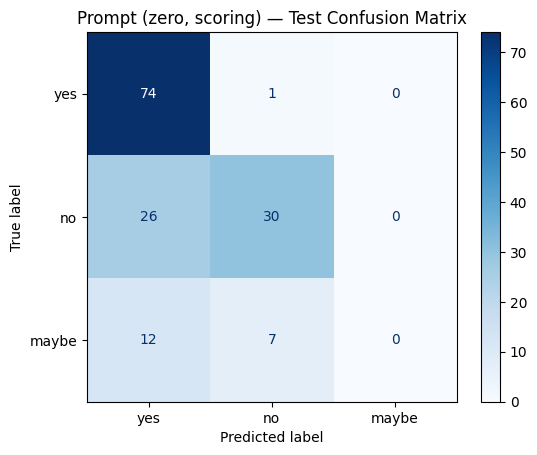

[zero] logged: ./runs_pubmedqa/experiment_log.jsonl
[zero] leaderboard updated: ./runs_pubmedqa/experiment_leaderboard.csv

=== Prompt Test Report — domain (scoring) ===
              precision    recall  f1-score   support

         yes       0.69      0.96      0.80        75
          no       0.80      0.66      0.73        56
       maybe       0.00      0.00      0.00        19

    accuracy                           0.73       150
   macro avg       0.50      0.54      0.51       150
weighted avg       0.65      0.73      0.67       150



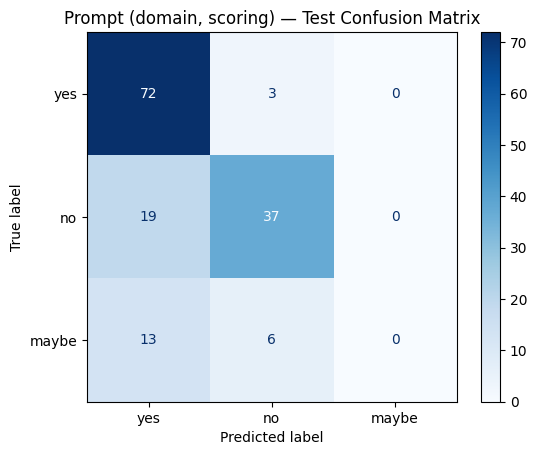

[domain] logged: ./runs_pubmedqa/experiment_log.jsonl
[domain] leaderboard updated: ./runs_pubmedqa/experiment_leaderboard.csv

=== Prompt Test Report — cot (scoring) ===
              precision    recall  f1-score   support

         yes       0.63      0.76      0.69        75
          no       0.59      0.62      0.61        56
       maybe       0.00      0.00      0.00        19

    accuracy                           0.61       150
   macro avg       0.41      0.46      0.43       150
weighted avg       0.53      0.61      0.57       150



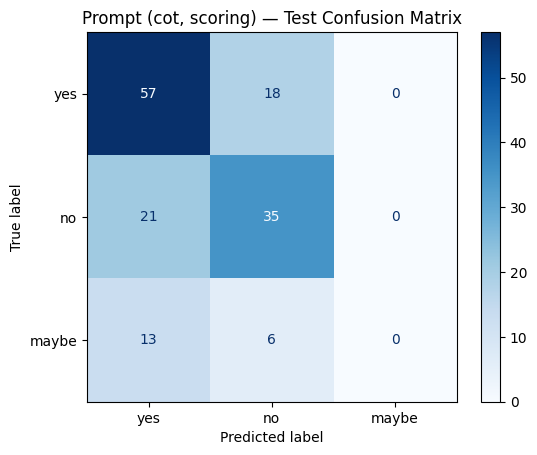

[cot] logged: ./runs_pubmedqa/experiment_log.jsonl
[cot] leaderboard updated: ./runs_pubmedqa/experiment_leaderboard.csv
artifacts saved to: ./runs_pubmedqa/artifacts/1758817601


In [14]:
import os, json, time, math
from datetime import datetime
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoModelForCausalLM
from peft import PeftModel

# --- helpers ---
def now_str():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def ensure_dir(p):
    os.makedirs(p, exist_ok=True); return p

def safe_float(x, default=0.0):
    try:
        if x is None: return default
        xf = float(x)
        if math.isnan(xf) or math.isinf(xf): return default
        return xf
    except Exception:
        return default

# # prompt builder fallback (if not defined earlier)
# if "build_prompt" not in globals():
#     def build_prompt(question, context, style="domain"):
#         if style == "zero":
#             return (
#                 "You are a helpful biomedical QA assistant.\n"
#                 f"Question: {question}\nContext: {context}\n"
#                 "Answer with exactly one word: yes, no, or maybe.\nAnswer:"
#             )
#         if style == "cot":
#             return (
#                 "You are a biomedical QA assistant. Think step by step.\n"
#                 f"Question: {question}\nContext: {context}\n"
#                 "First reason step-by-step, then on a new line output: Final answer: yes or no or maybe.\nReasoning:"
#             )
#         return (
#             "You are a biomedical QA assistant specialized in PubMed abstracts.\n"
#             "Use the context to answer exactly one word among: yes, no, maybe.\n\n"
#             f"Question: {question}\nContext: {context}\n\nAnswer:"
#         )


def score_labels_for_prompt(model, tokenizer, prompt_text, labels, device, max_len):
    """
    computes summed log-prob of each candidate label given the prompt.
    picks argmax over labels.
    """

    prompt_ids = tokenizer(prompt_text, return_tensors="pt", truncation=True, max_length=max_len)["input_ids"][0]
    best_label, best_lp = None, -1e30
    with torch.no_grad():
        for lab in labels:
            lab_text = " " + lab  # space helps produce the expected first token
            ids_full = tokenizer(prompt_text + lab_text, return_tensors="pt").to(device)["input_ids"][0]

            # figure out where the label tokens start in the full sequence
            ids_lab = tokenizer(lab_text, add_special_tokens=False, return_tensors="pt")["input_ids"][0]

            # if truncated, ensure we only score the tail that exists
            if len(ids_full) < len(ids_lab) + 1:
                
                lp = -1e30

            else:
                # forward pass on full
                out = model(input_ids=ids_full.unsqueeze(0).to(device))
                logits = out.logits[0]  # [seq, vocab]

                # positions corresponding to label tokens are the last len(ids_lab) steps
                start = logits.size(0) - len(ids_lab)

                # sum log-softmax probs of true label tokens at those positions
                logprobs = torch.log_softmax(logits[start-1:start-1+len(ids_lab)], dim=-1)

                # pick the probability assigned to the correct next token at each step
                token_lp = logprobs[torch.arange(len(ids_lab)), ids_lab.to(device)]
                lp = float(token_lp.sum().item())
            if lp > best_lp:
                best_lp, best_label = lp, lab
    return best_label, best_lp

# --- paths and run id ---
WORK_DIR = CONFIG["WORK_DIR"]
LOG_JSONL = os.path.join(WORK_DIR, "experiment_log.jsonl")
LEADERBOARD_CSV = os.path.join(WORK_DIR, "experiment_leaderboard.csv")
RUN_ID = os.environ.get("RUN_ID", str(int(time.time())))
RUN_DIR = ensure_dir(os.path.join(WORK_DIR, "artifacts", RUN_ID))

LABELS = ["yes", "no", "maybe"]
use_lora = bool(CONFIG.get("USE_QLORA", False))


if "ds" not in globals() or "test" not in ds:
    raise RuntimeError("Test split not found. Ensure the data loading cell created `ds['test']`.")

test_set = ds["test"]

# -------------------------
# path A: LoRA evaluation
# -------------------------
if use_lora:
    if "lora_model" not in globals() or lora_model is None:
        raise RuntimeError("LoRA model not found in memory. Train it first or set USE_QLORA=False for prompt baselines.")

    lora_model.eval()
    first_device = next(p.device for p in lora_model.parameters() if p.device.type != "meta")
    print(f"[LoRA] evaluating on device: {first_device}")

    preds, refs = [], []
    for ex in test_set:
        prompt = build_prompt(ex["question"], ex["context"], style="domain")
        # use the same scoring approach for consistency
        pred, _ = score_labels_for_prompt(
            lora_model, tokenizer, prompt, LABELS, first_device, CONFIG["MAX_INPUT_TOKENS"]
        )
        preds.append(pred)
        refs.append(ex["label"])

    # reports
    report = classification_report(refs, preds, labels=LABELS, output_dict=True, zero_division=0)
    print("\n=== LoRA Test Report ===")
    print(classification_report(refs, preds, labels=LABELS, zero_division=0))

    # confusion matrix
    cm = confusion_matrix(refs, preds, labels=LABELS)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    disp.plot(cmap="Purples")
    plt.title("LoRA — Test Confusion Matrix")
    plt.savefig(os.path.join(RUN_DIR, "lora_test_confusion_matrix.png"), bbox_inches="tight", dpi=150)
    plt.show()

    train_loss = safe_float(train_output.metrics.get("train_loss") if "train_output" in globals() else None)
    train_rt   = safe_float(train_output.metrics.get("train_runtime") if "train_output" in globals() else None)
    train_sps  = safe_float(train_output.metrics.get("train_samples_per_second") if "train_output" in globals() else None)

    summary = {
        "run_id": RUN_ID,
        "timestamp": now_str(),
        "mode": "qlora",
        "params": {
            "MODEL": CONFIG["LORA_BASE_MODEL"],
            "QLORA_RANK": CONFIG["QLORA_RANKS"][0],
            "MAX_INPUT_TOKENS": CONFIG["MAX_INPUT_TOKENS"],
            "LR": CONFIG["LR"],
            "EPOCHS": CONFIG["EPOCHS"],
            "GRAD_ACCUM_STEPS": CONFIG["GRAD_ACCUM_STEPS"],
            "PER_DEVICE_TRAIN_BS": CONFIG["PER_DEVICE_TRAIN_BS"],
            "PROMPT_STYLE": "domain",
        },
        "metrics": {
            "test_accuracy": safe_float(report.get("accuracy")),
            "test_macro_f1": safe_float(report.get("macro avg", {}).get("f1-score")),
            "train_loss": train_loss,
            "train_runtime": train_rt,
            "train_samples_per_second": train_sps,
        },
        "artifacts": {
            "test_confusion_matrix": os.path.join(RUN_DIR, "lora_test_confusion_matrix.png"),
        }
    }

    # write logs
    with open(LOG_JSONL, "a") as f:
        f.write(json.dumps(summary) + "\n")

    row = {
        "run_id": summary["run_id"],
        "timestamp": summary["timestamp"],
        "mode": summary["mode"],
        "model": summary["params"]["MODEL"],
        "rank": summary["params"]["QLORA_RANK"],
        "epochs": summary["params"]["EPOCHS"],
        "lr": summary["params"]["LR"],
        "val_acc": None,  
        "val_f1":  None,  
        "test_acc": summary["metrics"]["test_accuracy"],
        "test_f1": summary["metrics"]["test_macro_f1"],
    }
    if os.path.exists(LEADERBOARD_CSV):
        df_lb = pd.read_csv(LEADERBOARD_CSV)
        missing = [c for c in row.keys() if c not in df_lb.columns]
        for c in missing: df_lb[c] = pd.NA
        df_lb = df_lb[list(row.keys())]
    else:
        df_lb = pd.DataFrame(columns=list(row.keys()))
    df_lb = pd.concat([df_lb, pd.DataFrame([row])], ignore_index=True)
    df_lb.to_csv(LEADERBOARD_CSV, index=False)

    print(f"logged (JSONL): {LOG_JSONL}")
    print(f"leaderboard updated: {LEADERBOARD_CSV}")
    print(f"artifacts saved to: {RUN_DIR}")

# -----------------------------
# path B: Prompt baselines only
# -----------------------------
else:

    ##BEG
    # prompt_model_id = CONFIG["PROMPT_MODEL"]
    # prompt_model = AutoModelForCausalLM.from_pretrained(
    #     prompt_model_id,
    #     device_map="auto",
    #     #device_map={"":1},
    #     torch_dtype=torch.bfloat16 if CONFIG.get("BF16", False) else torch.float16,
    #     token=HF_TOKEN if "HF_TOKEN" in globals() and HF_TOKEN else None
    # )
    # prompt_model.eval()
    # first_device = next(p.device for p in prompt_model.parameters() if p.device.type != "meta")
    # print(f"[Prompt] evaluating on device: {first_device}")


    # for style in CONFIG.get("PROMPT_STYLES", ["zero","domain","cot"]):

    #     preds, refs = [], []
    #     for ex in test_set:
    #         prompt = build_prompt(ex["question"], ex["context"], style=style)
           
    #         pred, _ = score_labels_for_prompt(
    #             prompt_model, tokenizer, prompt, LABELS, first_device, CONFIG["MAX_INPUT_TOKENS"])
    #         preds.append(pred)
    #         refs.append(ex["label"])




    #     report = classification_report(refs, preds, labels=LABELS, output_dict=True, zero_division=0)
    #     print(f"\n=== Prompt Test Report — {style} ===")
    #     print(classification_report(refs, preds, labels=LABELS, zero_division=0))


    #     cm = confusion_matrix(refs, preds, labels=LABELS)
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    #     disp.plot(cmap="Blues")
    #     plt.title(f"Prompt ({style}) — Test Confusion Matrix")
    #     fig_path = os.path.join(RUN_DIR, f"prompt_{style}_test_confusion_matrix.png")
    #     plt.savefig(fig_path, bbox_inches="tight", dpi=150)
    #     plt.show()

    #     summary = {
    #         "run_id": RUN_ID,
    #         "timestamp": now_str(),
    #         "mode": f"prompt/{style}",
    #         "params": {
    #             "MODEL": prompt_model_id,
    #             "PROMPT_STYLE": style,
    #             "MAX_INPUT_TOKENS": CONFIG["MAX_INPUT_TOKENS"],
    #             "MAX_NEW_TOKENS": CONFIG["MAX_NEW_TOKENS"],
    #         },
    #         "metrics": {
    #             "test_accuracy": safe_float(report.get("accuracy")),
    #             "test_macro_f1": safe_float(report.get("macro avg", {}).get("f1-score")),
    #         },
    #         "artifacts": {
    #             "test_confusion_matrix": fig_path,
    #         }
    #     }

    #     with open(LOG_JSONL, "a") as f:
    #         f.write(json.dumps(summary) + "\n")

    #     row = {
    #         "run_id": summary["run_id"],
    #         "timestamp": summary["timestamp"],
    #         "mode": summary["mode"],
    #         "model": summary["params"]["MODEL"],
    #         "rank": None,     
    #         "epochs": None,   
    #         "lr": None,       
    #         "val_acc": None,  
    #         "val_f1": None,   
    #         "test_acc": summary["metrics"]["test_accuracy"],
    #         "test_f1": summary["metrics"]["test_macro_f1"],
    #     }
    #     if os.path.exists(LEADERBOARD_CSV):
    #         df_lb = pd.read_csv(LEADERBOARD_CSV)
    #         missing = [c for c in row.keys() if c not in df_lb.columns]
    #         for c in missing: df_lb[c] = pd.NA
    #         df_lb = df_lb[list(row.keys())]
    #     else:
    #         df_lb = pd.DataFrame(columns=list(row.keys()))
    #     df_lb = pd.concat([df_lb, pd.DataFrame([row])], ignore_index=True)
    #     df_lb.to_csv(LEADERBOARD_CSV, index=False)

    #     print(f"[{style}] logged (JSONL): {LOG_JSONL}")
    #     print(f"[{style}] leaderboard updated: {LEADERBOARD_CSV}")

    # print(f"artifacts saved to: {RUN_DIR}")
    
    prompt_model_id = CONFIG["PROMPT_MODEL"]
    prompt_model = AutoModelForCausalLM.from_pretrained(
        prompt_model_id,
        device_map="auto",
        torch_dtype=torch.bfloat16 if CONFIG.get("BF16", False) else torch.float16,
        token=HF_TOKEN if "HF_TOKEN" in globals() and HF_TOKEN else None
    )
    prompt_model.eval()
    first_device = next(p.device for p in prompt_model.parameters() if p.device.type != "meta")
    print(f"[Prompt] evaluating on device: {first_device}")

    # toggle method: "scoring" (logits) or "generate" (sampling)
    eval_method = CONFIG.get("PROMPT_EVAL_METHOD", "scoring")

    for style in CONFIG.get("PROMPT_STYLES", ["zero", "domain", "cot"]):
        preds, refs = [], []
        for ex in test_set:
            prompt = build_prompt(ex["question"], ex["context"], style=style)
            enc = tokenizer(prompt, return_tensors="pt", truncation=True,
                            max_length=CONFIG["MAX_INPUT_TOKENS"])
            enc = {k: v.to(first_device) for k, v in enc.items()}

            if eval_method == "generate":
                out = prompt_model.generate(
                    **enc,
                    max_new_tokens=CONFIG["MAX_NEW_TOKENS"],
                    do_sample=CONFIG.get("DO_SAMPLE", True),
                    temperature=CONFIG.get("GENERATION_TEMPERATURE", 0.3),
                    top_p=CONFIG.get("TOP_P", 0.9)
                )
                decoded = tokenizer.decode(out[0], skip_special_tokens=True)
                pred = parse_label(decoded)
            else:  # logit scoring
                pred, _ = score_labels_for_prompt(
                    prompt_model, tokenizer, prompt, LABELS, first_device, CONFIG["MAX_INPUT_TOKENS"]
                )

            preds.append(pred)
            refs.append(ex["label"])

        # report + confusion matrix
        report = classification_report(refs, preds, labels=LABELS, output_dict=True, zero_division=0)
        print(f"\n=== Prompt Test Report — {style} ({eval_method}) ===")
        print(classification_report(refs, preds, labels=LABELS, zero_division=0))

        cm = confusion_matrix(refs, preds, labels=LABELS)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
        disp.plot(cmap="Blues")
        plt.title(f"Prompt ({style}, {eval_method}) — Test Confusion Matrix")
        fig_path = os.path.join(RUN_DIR, f"prompt_{style}_{eval_method}_confusion_matrix.png")
        plt.savefig(fig_path, bbox_inches="tight", dpi=150)
        plt.show()

        # save logs
        summary = {
            "run_id": RUN_ID,
            "timestamp": now_str(),
            "mode": f"prompt/{style}/{eval_method}",
            "params": {
                "MODEL": prompt_model_id,
                "PROMPT_STYLE": style,
                "MAX_INPUT_TOKENS": CONFIG["MAX_INPUT_TOKENS"],
                "MAX_NEW_TOKENS": CONFIG["MAX_NEW_TOKENS"],
                "EVAL_METHOD": eval_method,
            },
            "metrics": {
                "test_accuracy": safe_float(report.get("accuracy")),
                "test_macro_f1": safe_float(report.get("macro avg", {}).get("f1-score")),
            },
            "artifacts": {"test_confusion_matrix": fig_path}
        }
        with open(LOG_JSONL, "a") as f:
            f.write(json.dumps(summary) + "\n")

        row = {
            "run_id": summary["run_id"],
            "timestamp": summary["timestamp"],
            "mode": summary["mode"],
            "model": summary["params"]["MODEL"],
            "test_acc": summary["metrics"]["test_accuracy"],
            "test_f1": summary["metrics"]["test_macro_f1"],
        }
        df_lb = pd.read_csv(LEADERBOARD_CSV) if os.path.exists(LEADERBOARD_CSV) else pd.DataFrame(columns=row.keys())
        df_lb = pd.concat([df_lb, pd.DataFrame([row])], ignore_index=True)
        df_lb.to_csv(LEADERBOARD_CSV, index=False)

        print(f"[{style}] logged: {LOG_JSONL}")
        print(f"[{style}] leaderboard updated: {LEADERBOARD_CSV}")

    print(f"artifacts saved to: {RUN_DIR}")


In [15]:
#!rm -f "{CONFIG['WORK_DIR']}/experiment_log.jsonl" "{CONFIG['WORK_DIR']}/experiment_leaderboard.csv"


# Results and Plots

Loaded CSV rows: 88


,run_id,timestamp,mode,model,rank,epochs,lr,test_acc,test_f1,runtime_sec,gpu_mem_max_mb,gpu_name
53,1758623855,2025-09-23 10:39:47,qlora,meta-llama/Meta-Llama-3.1-8B,16.0,7.0,0.00002,0.913333,0.847478,NaN,NaN,NaN
56,1758654570,2025-09-23 19:11:42,qlora,meta-llama/Meta-Llama-3.1-8B,8.0,5.0,0.00003,0.913333,0.854231,NaN,NaN,NaN
54,1758636905,2025-09-23 14:17:18,qlora,meta-llama/Meta-Llama-3.1-8B,4.0,5.0,0.00003,0.913333,0.854231,NaN,NaN,NaN
55,1758640741,2025-09-23 15:21:14,qlora,meta-llama/Meta-Llama-3.1-8B,4.0,7.0,0.00002,0.913333,0.847478,NaN,NaN,NaN
51,1758565325,2025-09-22 18:24:21,qlora,meta-llama/Meta-Llama-3.1-8B,16.0,5.0,0.00003,0.913333,0.854231,NaN,NaN,NaN
52,1758619710,2025-09-23 09:30:43,qlora,meta-llama/Meta-Llama-3.1-8B,8.0,7.0,0.00002,0.913333,0.847478,NaN,NaN,NaN
50,1758500237,2025-09-22 00:19:33,qlora,meta-llama/Meta-Llama-3.1-8B,8.0,5.0,0.00003,0.913333,0.854231,NaN,NaN,NaN
57,1758628052,2025-09-23 11:49:44,qlora,meta-llama/Meta-Llama-3.1-8B,16.0,15.0,0.00001,0.840000,0.818353,NaN,NaN,NaN
58,1758632685,2025-09-23 13:06:57,qlora,meta-llama/Meta-Llama-3.1-8B,4.0,15.0,0.00001,0.840000,0.818353,NaN,NaN,NaN
59,1758476432,2025-09-21 18:40:38,qlora,meta-llama/Meta-Llama-3.1-8B,8.0,5.0,0.00003,0.833333,0.820111,NaN,NaN,NaN



Best test metrics per mode (from CSV):


,mode,timestamp,run_id,model,test_acc,test_f1
50,qlora,2025-09-22 00:19:33,1758500237,meta-llama/Meta-Llama-3.1-8B,0.913333,0.854231
86,prompt/domain/scoring,2025-09-25 16:29:35,1758817601,meta-llama/Meta-Llama-3.1-8B,0.726667,0.509986
28,prompt/domain,2025-09-24 12:17:26,1758715963,meta-llama/Meta-Llama-3.1-8B,0.726667,0.509986
75,prompt/cot/scoring,2025-09-25 11:26:42,1758799360,meta-llama/Meta-Llama-3.1-8B,0.700000,0.631382
71,prompt/cot,2025-09-25 10:53:59,1758797396,meta-llama/Meta-Llama-3.1-8B,0.700000,0.631382
39,prompt/zero,2025-09-24 12:16:14,1758715963,meta-llama/Meta-Llama-3.1-8B,0.693333,0.476581
85,prompt/zero/scoring,2025-09-25 16:27:51,1758817601,meta-llama/Meta-Llama-3.1-8B,0.693333,0.476581


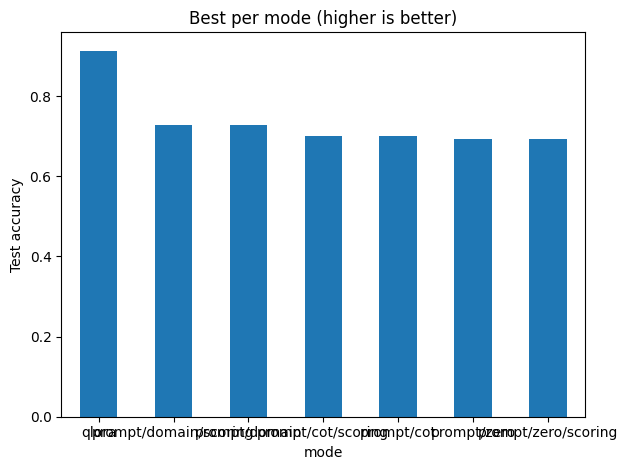

In [16]:
import os, json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display

WORK_DIR = Path(CONFIG["WORK_DIR"])
LOG_JSONL = WORK_DIR / "experiment_log.jsonl"
LEADERBOARD_CSV = WORK_DIR / "experiment_leaderboard.csv"

def load_csv_as_df(path: Path) -> pd.DataFrame:
    if path.exists():
        try:
            return pd.read_csv(path)
        except Exception:
            pass
    return pd.DataFrame()

def coerce_numeric(df: pd.DataFrame, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df


df_csv = load_csv_as_df(LEADERBOARD_CSV)
print(f"Loaded CSV rows: {len(df_csv)}")

if not df_csv.empty:

    drop_cols = [c for c in ["val_acc", "val_f1"] if c in df_csv.columns]
    dfc = df_csv.drop(columns=drop_cols, errors="ignore")


    dfc = coerce_numeric(dfc, ["rank", "epochs", "lr", "test_acc", "test_f1"])

    # show top runs sorted by test_acc (fallback test_f1)
    sort_col = "test_acc" if "test_acc" in dfc.columns else ("test_f1" if "test_f1" in dfc.columns else None)
    if sort_col:
        display(dfc.sort_values(sort_col, ascending=False).head(10))
    else:
        display(dfc.head(10))

    # best-per-mode summary
    if "mode" in dfc.columns and "test_acc" in dfc.columns:
        dfm = dfc.dropna(subset=["test_acc", "mode"])
        if not dfm.empty:
            idx = dfm.groupby("mode")["test_acc"].idxmax()
            best_per_mode = dfm.loc[idx, ["mode", "timestamp", "run_id", "model", "test_acc", "test_f1"]] \
                               .sort_values("test_acc", ascending=False)
            print("\nBest test metrics per mode (from CSV):")
            display(best_per_mode)

            # bar plot
            plt.figure()
            best_per_mode.set_index("mode")[["test_acc"]].plot(kind="bar", legend=False, ax=plt.gca())
            plt.ylabel("Test accuracy")
            plt.title("Best per mode (higher is better)")
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()
else:
    print("No leaderboard CSV yet.")

display(HTML(f"""
<hr>
<p><b>Logged files:</b></p>
<ul>
  <li><a href="{LOG_JSONL}" target="_blank">JSONL log file</a></li>
  <li><a href="{LEADERBOARD_CSV}" target="_blank">Leaderboard CSV</a></li>
</ul>
"""))


In [17]:
# # === Merge JSONL (detailed) + CSV (leaderboard) into one tidy table ===
# import os, json
# from pathlib import Path
# import pandas as pd
# from IPython.display import display

# WORK_DIR = Path(CONFIG["WORK_DIR"])
# LOG_JSONL = WORK_DIR / "experiment_log.jsonl"
# LEADERBOARD_CSV = WORK_DIR / "experiment_leaderboard.csv"
# OUT_DIR = WORK_DIR / "summaries"
# OUT_DIR.mkdir(parents=True, exist_ok=True)

# # ---------- loaders ----------
# def load_jsonl_df(path: Path) -> pd.DataFrame:
#     rows = []
#     if path.exists():
#         with open(path, "r") as f:
#             for line in f:
#                 line = line.strip()
#                 if not line:
#                     continue
#                 try:
#                     rows.append(json.loads(line))
#                 except json.JSONDecodeError:
#                     pass
#     return pd.json_normalize(rows) if rows else pd.DataFrame()

# def load_csv_df(path: Path) -> pd.DataFrame:
#     if path.exists():
#         try:
#             return pd.read_csv(path)
#         except Exception:
#             pass
#     return pd.DataFrame()

# def coerce_numeric(df: pd.DataFrame, cols):
#     for c in cols:
#         if c in df.columns:
#             df[c] = pd.to_numeric(df[c], errors="coerce")
#     return df

# def std_key_series(s):
#     """force join keys to strings and strip trailing '.0'"""
#     if s is None:
#         return pd.Series([], dtype="object")
#     s = s.astype(str).str.strip()
#     return s.str.replace(r"\.0$", "", regex=True)

# def first_nonnull(*vals):
#     for v in vals:
#         if pd.notna(v):
#             return v
#     return pd.NA

# print(f"Reading:\n- JSONL: {LOG_JSONL}\n- CSV:    {LEADERBOARD_CSV}")
# dfj_raw = load_jsonl_df(LOG_JSONL)
# dfc_raw = load_csv_df(LEADERBOARD_CSV)
# print(f"Loaded JSONL rows: {len(dfj_raw)}")
# print(f"Loaded CSV rows:   {len(dfc_raw)}")

# # ---------- project JSONL to canonical schema ----------
# # Pulls: run info, test metrics, train metrics, runtime_sec, GPU mem
# def project_jsonl(df: pd.DataFrame) -> pd.DataFrame:
#     if df.empty:
#         return pd.DataFrame(columns=[
#             "run_id","mode","timestamp","model","rank","epochs","lr",
#             "test_acc","test_f1","train_loss","train_runtime","train_sps",
#             "runtime_sec","gpu_name","gpu_mem_max_mb","gpu_mem_allocated_mb","gpu_mem_reserved_mb"
#         ])
#     out = pd.DataFrame()
#     out["run_id"]    = df.get("run_id")
#     out["mode"]      = df.get("mode")
#     out["timestamp"] = df.get("timestamp")
#     out["model"]     = df.get("params.MODEL", df.get("model"))
#     out["rank"]      = df.get("params.QLORA_RANK")
#     out["epochs"]    = df.get("params.EPOCHS")
#     out["lr"]        = df.get("params.LR")
#     out["test_acc"]  = df.get("metrics.test_accuracy")
#     out["test_f1"]   = df.get("metrics.test_macro_f1")
#     out["train_loss"]   = df.get("metrics.train_loss")
#     out["train_runtime"]= df.get("metrics.train_runtime")
#     out["train_sps"]    = df.get("metrics.train_samples_per_second")
#     # efficiency (either 'efficiency' or older 'env.gpu')
#     out["runtime_sec"] = df.get("efficiency.runtime_sec", df.get("runtime_sec"))
#     out["gpu_name"]    = df.get("efficiency.gpu.gpu_name",  df.get("env.gpu.gpu_name"))
#     out["gpu_mem_max_mb"]      = df.get("efficiency.gpu.max_mem_allocated_mb", df.get("env.gpu.max_mem_allocated_mb"))
#     out["gpu_mem_allocated_mb"] = df.get("efficiency.gpu.mem_allocated_mb", df.get("env.gpu.mem_allocated_mb"))
#     out["gpu_mem_reserved_mb"]  = df.get("efficiency.gpu.mem_reserved_mb",  df.get("env.gpu.mem_reserved_mb"))
#     out = coerce_numeric(out, ["rank","epochs","lr","test_acc","test_f1","train_loss","train_runtime","train_sps",
#                                "runtime_sec","gpu_mem_max_mb","gpu_mem_allocated_mb","gpu_mem_reserved_mb"])
#     out["run_id"] = std_key_series(out["run_id"])
#     out["mode"]   = std_key_series(out["mode"]).str.lower()
#     return out

# # ---------- project CSV to schema (some columns may be missing) ----------
# def project_csv(df: pd.DataFrame) -> pd.DataFrame:
#     if df.empty:
#         return pd.DataFrame(columns=[
#             "run_id","mode","timestamp","model","rank","epochs","lr",
#             "test_acc","test_f1","train_loss","train_runtime","train_sps",
#             "runtime_sec","gpu_name","gpu_mem_max_mb","gpu_mem_allocated_mb","gpu_mem_reserved_mb"
#         ])
#     keep = ["run_id","mode","timestamp","model","rank","epochs","lr",
#             "test_acc","test_f1","train_loss","train_runtime","train_sps",
#             "runtime_sec","gpu_name","gpu_mem_max_mb","gpu_mem_allocated_mb","gpu_mem_reserved_mb"]
#     for k in keep:
#         if k not in df.columns:
#             df[k] = pd.NA
#     out = df[keep].copy()
#     out = coerce_numeric(out, ["rank","epochs","lr","test_acc","test_f1","train_loss","train_runtime","train_sps",
#                                "runtime_sec","gpu_mem_max_mb","gpu_mem_allocated_mb","gpu_mem_reserved_mb"])
#     out["run_id"] = std_key_series(out["run_id"])
#     out["mode"]   = std_key_series(out["mode"]).str.lower()
#     return out

# dfj = project_jsonl(dfj_raw)
# dfc = project_csv(dfc_raw)

# # ---------- merge on (run_id, mode), prefer JSONL values ----------
# if dfj.empty and dfc.empty:
#     merged = pd.DataFrame(columns=[
#         "run_id","mode","timestamp","model","rank","epochs","lr",
#         "test_acc","test_f1","train_loss","train_runtime","train_sps",
#         "runtime_sec","gpu_name","gpu_mem_max_mb","gpu_mem_allocated_mb","gpu_mem_reserved_mb"
#     ])
# elif dfj.empty:
#     merged = dfc.copy()
# elif dfc.empty:
#     merged = dfj.copy()
# else:
#     base = pd.merge(dfj, dfc, on=["run_id","mode"], how="outer", suffixes=("_j","_c"))
#     def col(j, c):
#         return base.apply(lambda r: first_nonnull(r.get(j), r.get(c)), axis=1)
#     merged = pd.DataFrame({
#         "run_id": base["run_id"],
#         "mode":   base["mode"],
#         "timestamp": col("timestamp_j","timestamp_c"),
#         "model":     col("model_j","model_c"),
#         "rank":      col("rank_j","rank_c"),
#         "epochs":    col("epochs_j","epochs_c"),
#         "lr":        col("lr_j","lr_c"),
#         "test_acc":  col("test_acc_j","test_acc_c"),
#         "test_f1":   col("test_f1_j","test_f1_c"),
#         "train_loss":    col("train_loss_j","train_loss_c"),
#         "train_runtime": col("train_runtime_j","train_runtime_c"),
#         "train_sps":     col("train_sps_j","train_sps_c"),
#         "runtime_sec":       col("runtime_sec_j","runtime_sec_c"),
#         "gpu_name":          col("gpu_name_j","gpu_name_c"),
#         "gpu_mem_max_mb":    col("gpu_mem_max_mb_j","gpu_mem_max_mb_c"),
#         "gpu_mem_allocated_mb": col("gpu_mem_allocated_mb_j","gpu_mem_allocated_mb_c"),
#         "gpu_mem_reserved_mb":  col("gpu_mem_reserved_mb_j","gpu_mem_reserved_mb_c"),
#     })
#     merged = coerce_numeric(merged, ["rank","epochs","lr","test_acc","test_f1","train_loss","train_runtime","train_sps",
#                                      "runtime_sec","gpu_mem_max_mb","gpu_mem_allocated_mb","gpu_mem_reserved_mb"])

# # drop incomplete keys
# merged = merged.dropna(subset=["run_id","mode"], how="any")

# # de-duplicate within (run_id, mode): keep row with **more** filled metrics, break ties by best test_acc
# def score_row(row):
#     filled = row[["test_acc","test_f1","train_loss","train_runtime","runtime_sec","gpu_mem_max_mb"]].notna().sum()
#     return (filled, row.get("test_acc") if pd.notna(row.get("test_acc")) else -1)

# merged_sorted = merged.sort_values(by=["run_id","mode","test_acc"], ascending=[True, True, False])
# best_rows = []
# for (_, g) in merged_sorted.groupby(["run_id","mode"]):
#     # pick row with highest (filled-metrics, test_acc)
#     idx = max(range(len(g)), key=lambda i: score_row(g.iloc[i]))
#     best_rows.append(g.iloc[idx])
# merged_best = pd.DataFrame(best_rows).reset_index(drop=True)

# # sort nicely and show
# merged_best = merged_best.sort_values(["mode","test_acc","timestamp"], ascending=[True, False, True])
# display(merged_best.head(30))

# # write outputs: backup old CSV, overwrite main, and also write a merged copy
# if LEADERBOARD_CSV.exists():
#     backup = OUT_DIR / f"leaderboard_backup.csv"
#     dfc_raw.to_csv(backup, index=False)
#     print(f"Backed up old CSV → {backup}")

# merged_best.to_csv(LEADERBOARD_CSV, index=False)
# merged_best.to_csv(OUT_DIR / "leaderboard_merged.csv", index=False)
# print(f"Updated leaderboard → {LEADERBOARD_CSV}")
# print(f"Saved merged copy   → {OUT_DIR/'leaderboard_merged.csv'}")


# Log GPU Memory Consumption

In [18]:
import os, json, time
from datetime import datetime
import pandas as pd
import torch

WORK_DIR = CONFIG["WORK_DIR"]
LOG_JSONL = os.path.join(WORK_DIR, "experiment_log.jsonl")
LEADERBOARD_CSV = os.path.join(WORK_DIR, "experiment_leaderboard.csv")

def now_str():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def gpu_stats_dict():
    if not torch.cuda.is_available():
        return {}
    return {
        "gpu_index": torch.cuda.current_device(),
        "gpu_name": torch.cuda.get_device_name(0),
        "mem_allocated_mb": round(torch.cuda.memory_allocated() / 1024**2, 2),
        "mem_reserved_mb": round(torch.cuda.memory_reserved() / 1024**2, 2),
        "max_mem_allocated_mb": round(torch.cuda.max_memory_allocated() / 1024**2, 2),
        "max_mem_reserved_mb": round(torch.cuda.max_memory_reserved() / 1024**2, 2),
    }


run_id    = RUN_ID if "RUN_ID" in globals() else str(int(time.time()))
mode      = "qlora" if CONFIG.get("USE_QLORA") else f"prompt/{CONFIG.get('PROMPT_STYLES', ['zero'])[0]}"
model_id  = CONFIG["LORA_BASE_MODEL"] if CONFIG.get("USE_QLORA") else CONFIG["PROMPT_MODEL"]
runtime_s = round(time.time() - START_TIME, 2) if "START_TIME" in globals() else None
gpu_info  = gpu_stats_dict()

util_entry = {
    "run_id": run_id,
    "timestamp": now_str(),
    "mode": mode,
    "model": model_id,
    "runtime_sec": runtime_s,
    "gpu": gpu_info,
}

os.makedirs(WORK_DIR, exist_ok=True)
with open(LOG_JSONL, "a") as f:
    f.write(json.dumps(util_entry) + "\n")

util_cols = ["runtime_sec", "gpu_mem_max_mb", "gpu_name"]
row_update = {
    "run_id": run_id,
    "runtime_sec": runtime_s,
    "gpu_mem_max_mb": gpu_info.get("max_mem_allocated_mb", None) if gpu_info else None,
    "gpu_name": gpu_info.get("gpu_name", None) if gpu_info else None,
}

if os.path.exists(LEADERBOARD_CSV):
    df = pd.read_csv(LEADERBOARD_CSV)
else:
    df = pd.DataFrame(columns=[
        "run_id","timestamp","mode","model","rank","epochs","lr",
        "test_acc","test_f1","runtime_sec","gpu_mem_max_mb","gpu_name","train_loss"
    ])

for c in row_update.keys():
    if c not in df.columns:
        df[c] = pd.NA

idx = df.index[df["run_id"] == run_id].tolist()
if idx:
    i = idx[0]
    for k, v in row_update.items():
        df.at[i, k] = v
else:

    df = pd.concat([df, pd.DataFrame([row_update])], ignore_index=True)

df.to_csv(LEADERBOARD_CSV, index=False)

print("=== Utilization captured ===")
print(json.dumps(util_entry, indent=2))
print(f"Appended to JSONL: {LOG_JSONL}")
print(f"Upserted in CSV:   {LEADERBOARD_CSV}")


=== Utilization captured ===
{
  "run_id": "1758817601",
  "timestamp": "2025-09-25 16:31:20",
  "mode": "prompt/zero",
  "model": "meta-llama/Meta-Llama-3.1-8B",
  "runtime_sec": 279.01,
  "gpu": {
    "gpu_index": 0,
    "gpu_name": "NVIDIA RTX A5000",
    "mem_allocated_mb": 6834.7,
    "mem_reserved_mb": 9656.0,
    "max_mem_allocated_mb": 7330.03,
    "max_mem_reserved_mb": 9656.0
  }
}
Appended to JSONL: ./runs_pubmedqa/experiment_log.jsonl
Upserted in CSV:   ./runs_pubmedqa/experiment_leaderboard.csv


In [19]:
#   Merge duplicate entries for a run_id 
# import os, json
# import pandas as pd
# from pathlib import Path

# WORK_DIR = Path(CONFIG["WORK_DIR"])
# CSV_PATH = WORK_DIR / "experiment_leaderboard.csv"
# JSONL_PATH = WORK_DIR / "experiment_log.jsonl"

# # map JSONL keys to CSV columns
# JSONL_TO_CSV = {
#     "timestamp": "timestamp",
#     "mode": "mode",
#     "params.MODEL": "model",
#     "params.QLORA_RANK": "rank",
#     "params.EPOCHS": "epochs",
#     "params.LR": "lr",
#     "metrics.val_accuracy": "val_acc",
#     "metrics.val_macro_f1": "val_f1",
#     "metrics.test_accuracy": "test_acc",
#     "metrics.test_macro_f1": "test_f1",
#     "metrics.train_loss": "train_loss",
#     "metrics.train_runtime": "runtime_sec",
#     "env.gpu.gpu_name": "gpu_name",
#     "env.gpu.max_mem_allocated_mb": "gpu_mem_max_mb",
# }

# NUMERIC_COLS = [
#     "rank","epochs","lr","val_acc","val_f1","test_acc","test_f1",
#     "runtime_sec","gpu_mem_max_mb","train_loss"
# ]

# def _norm_runid(x) -> str:
#     """normalize run_id to a clean string (handles ints, floats, strings)."""
#     if pd.isna(x):
#         return ""
#     if isinstance(x, (int,)):
#         return str(x)
#     if isinstance(x, float):
#         # handle floats serialized from CSV (e.g., 1.758476432e+09 or 1758476432.0)
#         return str(int(x))
#     s = str(x).strip()
#     # common cases: "1758476432.0" or "1.758476432e+09"
#     try:
#         if "." in s or "e+" in s.lower() or "e-" in s.lower():
#             return str(int(float(s)))
#     except Exception:
#         pass
#     return s

# def _load_csv(csv_path: Path) -> pd.DataFrame:
#     if not csv_path.exists():
#         return pd.DataFrame()
#     df = pd.read_csv(csv_path)
#     if "run_id" in df.columns:
#         df["run_id"] = df["run_id"].apply(_norm_runid)
#     for c in NUMERIC_COLS:
#         if c in df.columns:
#             df[c] = pd.to_numeric(df[c], errors="coerce")
#     return df

# def _load_jsonl(jsonl_path: Path) -> pd.DataFrame:
#     rows = []
#     if jsonl_path.exists():
#         with open(jsonl_path, "r") as f:
#             for line in f:
#                 line = line.strip()
#                 if not line:
#                     continue
#                 try:
#                     rows.append(json.loads(line))
#                 except json.JSONDecodeError:
#                     continue
#     if not rows:
#         return pd.DataFrame()
#     df = pd.json_normalize(rows)
#     if "run_id" in df.columns:
#         df["run_id"] = df["run_id"].apply(_norm_runid)
#     # coerce mapped numeric columns if they exist
#     for j_key, c_name in JSONL_TO_CSV.items():
#         if j_key in df.columns and c_name in NUMERIC_COLS:
#             df[j_key] = pd.to_numeric(df[j_key], errors="coerce")
#     return df

# def _jsonl_rows_to_csv_schema(sub_jsonl: pd.DataFrame) -> pd.DataFrame:
#     """convert JSONL normalized rows to the CSV schema via mapping."""
#     if sub_jsonl.empty:
#         return pd.DataFrame()
#     out = pd.DataFrame(index=sub_jsonl.index)
#     for j_key, c_name in JSONL_TO_CSV.items():
#         if j_key in sub_jsonl.columns:
#             out[c_name] = sub_jsonl[j_key]
#     # ensure essential identifiers exist
#     if "run_id" in sub_jsonl.columns:
#         out["run_id"] = sub_jsonl["run_id"]
#     return out

# def _merge_rows(rows: pd.DataFrame) -> dict:
#     """merge multiple rows (same schema) by taking the first non-null per column."""
#     merged = {}
#     for col in rows.columns:
#         vals = rows[col].dropna()
#         merged[col] = vals.iloc[0] if not vals.empty else pd.NA
#     return merged

# def merge_runid_entries(run_id: str, csv_path: Path = CSV_PATH, jsonl_path: Path = JSONL_PATH):
#     rid = _norm_runid(run_id)

#     df_csv = _load_csv(csv_path)
#     df_jl  = _load_jsonl(jsonl_path)

#     if df_csv.empty and df_jl.empty:
#         print("No logs found in either CSV or JSONL.")
#         return

#     # gather CSV rows
#     sub_csv = df_csv[df_csv.get("run_id", "").astype(str) == rid].copy()

#     # gather JSONL rows and map to CSV schema
#     sub_jl_raw = df_jl[df_jl.get("run_id", "").astype(str) == rid].copy()
#     sub_jl = _jsonl_rows_to_csv_schema(sub_jl_raw)

#     if sub_csv.empty and sub_jl.empty:
#         print(f"No entries found for run_id={rid} in CSV or JSONL.")
#         # optional: debug available ids
#         if not df_csv.empty:
#             print("CSV run_ids sample:", df_csv["run_id"].astype(str).unique()[:10])
#         if not df_jl.empty:
#             print("JSONL run_ids sample:", df_jl["run_id"].astype(str).unique()[:10])
#         return

#     # if multiple modes exist for this run_id (e.g., prompt/zero, prompt/cot),
#     # merge separately per mode to preserve comparability.
#     modes_csv = set(sub_csv["mode"].dropna().astype(str)) if "mode" in sub_csv.columns else set()
#     modes_jl  = set(sub_jl["mode"].dropna().astype(str))  if "mode" in sub_jl.columns  else set()
#     modes = modes_csv.union(modes_jl) or {pd.NA}

#     merged_rows = []
#     for m in modes:
#         # filter by mode (if available)
#         part_csv = sub_csv if m is pd.NA else sub_csv[sub_csv.get("mode").astype(str) == str(m)]
#         part_jl  = sub_jl  if m is pd.NA else sub_jl[sub_jl.get("mode").astype(str) == str(m)]

#         # align columns for merge
#         cols = sorted(set(part_csv.columns).union(part_jl.columns))
#         part_csv = part_csv.reindex(columns=cols)
#         part_jl  = part_jl.reindex(columns=cols)

#         # stack all candidate rows with a simple priority: more complete rows first
#         combined = pd.concat([part_csv, part_jl], ignore_index=True)
#         if combined.empty:
#             continue
#         combined["__nnz__"] = combined.notna().sum(axis=1)
#         combined = combined.sort_values("__nnz__", ascending=False).drop(columns="__nnz__")

#         merged = _merge_rows(combined)
#         merged["run_id"] = rid
#         if m is not pd.NA:
#             merged["mode"] = m
#         merged_rows.append(merged)

#     if not merged_rows:
#         print(f"No mergeable rows for run_id={rid}.")
#         return

#     # drop existing rows for this run_id (all modes) then append merged ones
#     df_new = df_csv[df_csv.get("run_id", "").astype(str) != rid].copy()
#     df_new = pd.concat([df_new, pd.DataFrame(merged_rows)], ignore_index=True)

#     # enforce column order (optional)
#     preferred_cols = [
#         "run_id","timestamp","mode","model","rank","epochs","lr",
#         "val_acc","val_f1","test_acc","test_f1",
#         "runtime_sec","gpu_mem_max_mb","gpu_name","train_loss"
#     ]
#     for c in preferred_cols:
#         if c not in df_new.columns:
#             df_new[c] = pd.NA
#     df_new = df_new[preferred_cols + [c for c in df_new.columns if c not in preferred_cols]]

#     # numeric coercion
#     for c in NUMERIC_COLS:
#         if c in df_new.columns:
#             df_new[c] = pd.to_numeric(df_new[c], errors="coerce")

#     df_new.to_csv(csv_path, index=False)

#     print(f"Merged duplicates for run_id={rid}.")
#     display(df_new[df_new["run_id"].astype(str) == rid])

# # --- usage ---
# merge_runid_entries("1758476432")



